In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
from astropy.table import Table

In [2]:
nickel_masses = [0.1239, 0.0441, 0.1105, 0.0684] 
sp14_masses = [0.1449, 0.0556, 0.110, 0.0802]

plateau_length = [88.04875493948131, 60.961046364568105, 91.10672254884823, 107.6711255152417]
upper_x = [1.3649329877384133, 0.4143178633084119, 1.4331253507989459, 0.8758284790054347]
lower_x = [1.2518999287058818,0.37478178341954305, 1.0693672610451301, 0.7930402759757413]

upper_y = [0.0024, 0.0004, 0.0028, 0.0017]
lower_y = [0.0021, 0.0004, 0.0024, 0.00170]
asymmetric_y = [lower_y, upper_y]
asymmetric_x = [lower_x, upper_x]

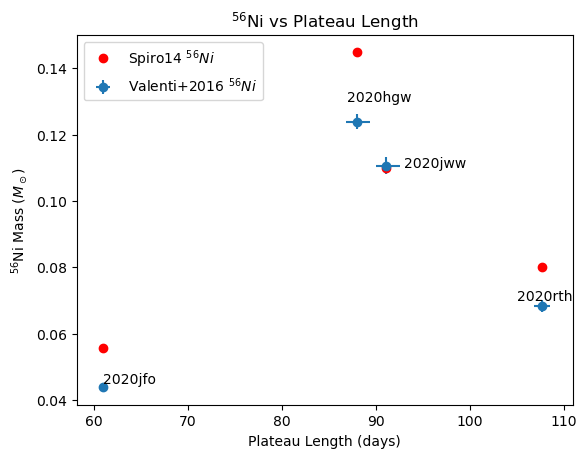

In [3]:


plt.figure()
plt.errorbar(plateau_length, nickel_masses, xerr=asymmetric_x, yerr=asymmetric_y, fmt = 'o', label = 'Valenti+2016 $^{56}Ni$')
plt.plot(plateau_length, sp14_masses, color = 'r', label = 'Spiro14 $^{56}Ni $', marker = 'o', linestyle = 'None') 

plt.text(61, 0.045, '2020jfo')
plt.text(87, 0.13, '2020hgw')
plt.text(93, 0.11, '2020jww')
plt.text(105, 0.07, '2020rth')
plt.title('$^{56}$Ni vs Plateau Length')
plt.xlabel('Plateau Length (days)')
plt.ylabel('$^{56}$Ni Mass $(M_\odot)$')
plt.legend(loc = 2)

### CURVEPOP SNE 
## 2003gd 
Anderson+2014, Galbany+2016, Fara,+2014, Hendry+2005b, Van Dyk+2003 
## 2004A 
Hendry+2006, Tsvetkov 2008 
## 2004et 
Maguire+2010 
## 2005cs 
Pastorello+2009
## 2006my 
Maguire+2010
## 2008bk
Anderson+2014, Van Dyk+2012 
## 2009md 
Fraser+2011 
## 2012A
Tomasella+2013 
## 2012aw 
Bose & Kumar 2013 
## 2012ec 
Smartt+ 2015 
## 2013ej 
Yuan+2016, Huang+2015


### NOTE 
2003gd, 2008bk do not have plateau estimates from Anderson+14 

In [4]:
#CURVEPOP SNe 
#2003gd, 2004A, 2004et, 2005cs, 2006my, 2008bk, 2009md, 2012A, 2012aw, 2012ec, 2013ej 
#2004A 80d +25, -5 
CURVE_tpt = [90, 80, 100, 110, 120, 100, 120, 85, 96, 90, 50]
CURVE_err = [10, 25, 0, 10, 20, 0, 0, 5, 11, 0, 0]
CURVE_uncons_ni = [10.0, 31.6, 31.6, 3.2, 17.7, 10.0, 3.2, 3.2, 56.2, 17.8, 100]
CURVE_uncons = np.array(CURVE_uncons_ni) * (10 ** (-3))
CURVE_uncons
uncons_err_upper = [3.3, 68.4, 10.5, 1.1, 82.2, 4.4, 3.3, 4.3, 1.1, 18.8, 5.9, 90]
uncons_err_lower = [2.5, 7.9, 7.9, 0.8, 4.4, 5.8, 1.8, 1.8, 14.1, 10.3,90]
uncons_upper = np.array(uncons_err_upper) * (10 **(-3))
uncons_lower = np.array(uncons_err_lower) * (10 ** (-3))
CURVE_cons_ni = [10.0, 31.6, 56.2, 3.2, 17.8, 10.0, 3.16, 10.0, 56.2, 17.8, 100]
CURVE_cons = np.array(CURVE_cons_ni) * (10 **(-3))
cons_err_upper = [3.3, 68.4, 18.8, 1.1, 82.2, 3.3, 4.3, 3.3, 18.8, 5.9, 82.2]
cons_err_lower = [2.5, 7.9, 14.1, 0.8, 4.4, 2.5, 1.8, 5.8, 14.1, 4.4, 82.2]
cons_upper = np.array(cons_err_upper)  * (10**(-3))
cons_lower = np.array(cons_err_lower) * (10 ** (-3)) 
print(CURVE_cons)

[0.01    0.0316  0.0562  0.0032  0.0178  0.01    0.00316 0.01    0.0562
 0.0178  0.1    ]


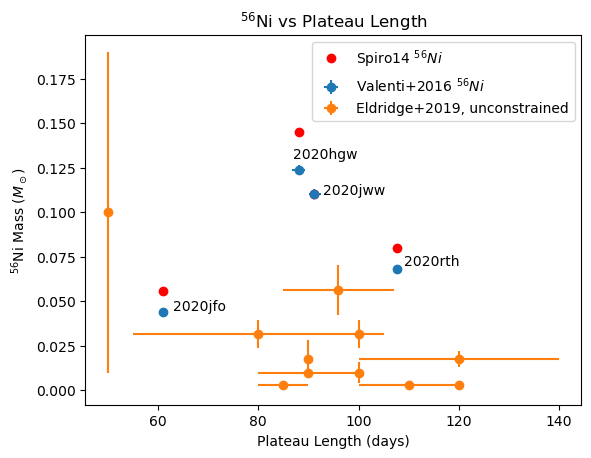

In [5]:
plt.errorbar(plateau_length, nickel_masses, xerr=asymmetric_x, yerr=asymmetric_y, fmt = 'o', label = 'Valenti+2016 $^{56}Ni$')
plt.plot(plateau_length, sp14_masses, color = 'r', label = 'Spiro14 $^{56}Ni $', marker = 'o', linestyle = 'None') 
plt.errorbar(CURVE_tpt, CURVE_uncons, xerr = CURVE_err, yerr = uncons_lower, fmt = 'o', label = r'Eldridge+2019, unconstrained')
plt.title('$^{56}$Ni vs Plateau Length')
plt.xlabel('Plateau Length (days)')
plt.ylabel('$^{56}$Ni Mass $(M_\odot)$')
plt.text(63, 0.045, '2020jfo')
plt.text(87, 0.13, '2020hgw')
plt.text(93, 0.11, '2020jww')
plt.text(109, 0.07, '2020rth')
plt.legend(loc = 1)

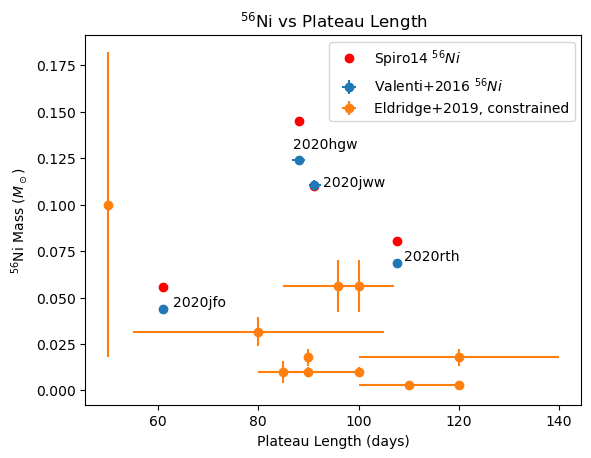

In [6]:
plt.errorbar(plateau_length, nickel_masses, xerr=asymmetric_x, yerr=asymmetric_y, fmt = 'o', label = 'Valenti+2016 $^{56}Ni$')
plt.plot(plateau_length, sp14_masses, color = 'r', label = 'Spiro14 $^{56}Ni $', marker = 'o', linestyle = 'None') 
plt.errorbar(CURVE_tpt, CURVE_cons, xerr = CURVE_err, yerr = cons_lower, fmt = 'o', label = r'Eldridge+2019, constrained')
plt.title('$^{56}$Ni vs Plateau Length')
plt.xlabel('Plateau Length (days)')
plt.ylabel('$^{56}$Ni Mass $(M_\odot)$')
plt.text(63, 0.045, '2020jfo')
plt.text(87, 0.13, '2020hgw')
plt.text(93, 0.11, '2020jww')
plt.text(109, 0.07, '2020rth')
plt.legend(loc = 1)

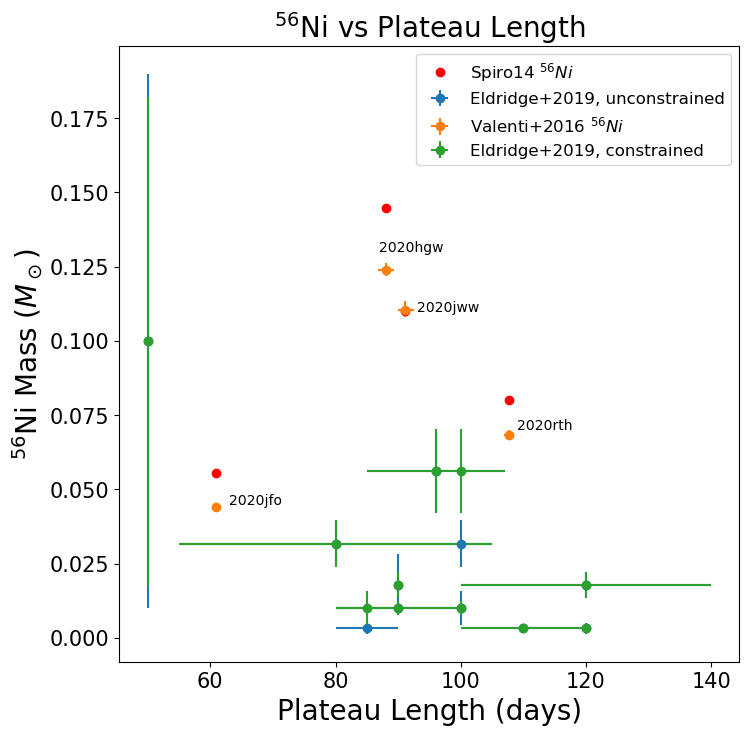

In [7]:
plt.figure(figsize=(8,8))
plt.errorbar(CURVE_tpt, CURVE_uncons, xerr = CURVE_err, yerr = uncons_lower, fmt = 'o', label = r'Eldridge+2019, unconstrained')
plt.errorbar(plateau_length, nickel_masses, xerr=asymmetric_x, yerr=asymmetric_y, fmt = 'o', label = 'Valenti+2016 $^{56}Ni$')
plt.plot(plateau_length, sp14_masses, color = 'r', label = 'Spiro14 $^{56}Ni $', marker = 'o', linestyle = 'None') 
plt.errorbar(CURVE_tpt, CURVE_cons, xerr = CURVE_err, yerr = cons_lower, fmt = 'o', label = r'Eldridge+2019, constrained')
plt.title('$^{56}$Ni vs Plateau Length', fontsize = 20)
plt.xlabel('Plateau Length (days)', fontsize = 20)
plt.ylabel('$^{56}$Ni Mass $(M_\odot)$', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.text(63, 0.045, '2020jfo')
plt.text(87, 0.13, '2020hgw')
plt.text(93, 0.11, '2020jww')
plt.text(109, 0.07, '2020rth')
plt.legend(loc = 1, fontsize = 'large')

Text(0.5, 1.0, '$^{56}$Ni vs Peak Luminosity')

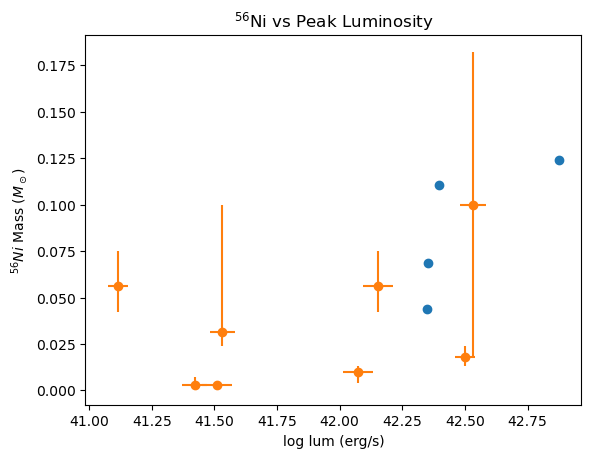

In [8]:
peak_lums = [7.499622138688114e+42, 2.224722485025017e+42, 2.4810434522392757e+42, 2.2496933248455278e+42]
peak_Ls = [np.nan, 41.531, 41.115, 41.511, np.nan, np.nan, 41.422, 42.073, 42.154, 42.502, 42.532]
errs_CURVE = [np.nan, 0.05, 0.04, 0.06, np.nan, np.nan, 0.05, 0.06, 0.06, 0.04, 0.05]

plt.figure()
plt.plot(np.log10(peak_lums), nickel_masses, marker = 'o', linestyle = 'none')
plt.errorbar(peak_Ls, CURVE_cons, xerr=errs_CURVE, yerr=[cons_lower, cons_upper], fmt='o')
plt.xlabel('log lum (erg/s)')
plt.ylabel('$^{56}Ni$ Mass ($M_\odot$)')
plt.title('$^{56}$Ni vs Peak Luminosity')

In [9]:
hgw_ni = 0.1239 
jfo_ni = 0.0441
jww_ni = 0.1105
rth_ni = 0.0684 

Text(0.5, 1.0, '56Ni vs Progenitor Mass')

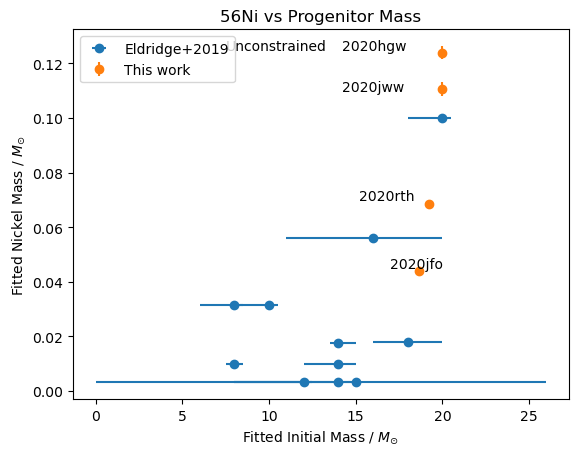

In [10]:
uncons_init = [8.0, 8.0, 10.0, 12.0, 14.0, 14.0, 14.0, 15.0, 16.0, 18.0, 20.0]
uncons_upper_init = [.5, .5, .5, .5, 1,1,1, 11, 4, 2, .5]
uncons_lower_init = [.5, 2, 2, 12, .5, 2, 6, 7, 5, 2, 2]
uncons_asym_init = [uncons_lower_init, uncons_upper_init]

hgw_uncons = np.interp(hgw_ni, CURVE_uncons, uncons_init)
jfo_uncons = np.interp(jfo_ni, CURVE_uncons, uncons_init)
jww_uncons = np.interp(jww_ni, CURVE_uncons, uncons_init)
rth_uncons = np.interp(rth_ni, CURVE_uncons, uncons_init)
uncons_init_array = np.array([hgw_uncons, jfo_uncons, jww_uncons, rth_uncons])
plt.errorbar(uncons_init, CURVE_uncons, xerr = uncons_asym_init, fmt = 'o', label = 'Eldridge+2019')
plt.errorbar(uncons_init_array, nickel_masses, yerr = asymmetric_y, fmt = 'o', label = 'This work')
plt.xlabel('Fitted Initial Mass / $M_{\odot}$')
plt.ylabel('Fitted Nickel Mass / $M_{\odot}$')
plt.legend()
plt.text(7.5, 0.125, 'Unconstrained')
plt.text(17, 0.045, '2020jfo')
plt.text(14.2, 0.125, '2020hgw')
plt.text(14.2, 0.11, '2020jww')
plt.text(15.2, 0.07, '2020rth')
plt.title('56Ni vs Progenitor Mass')

hgw_cons:18.0, jfo_cons:8.0, jww_cons:18.0, rth_cons:17.231143552311437


Text(0.5, 1.0, '56Ni vs Progenitor Mass')

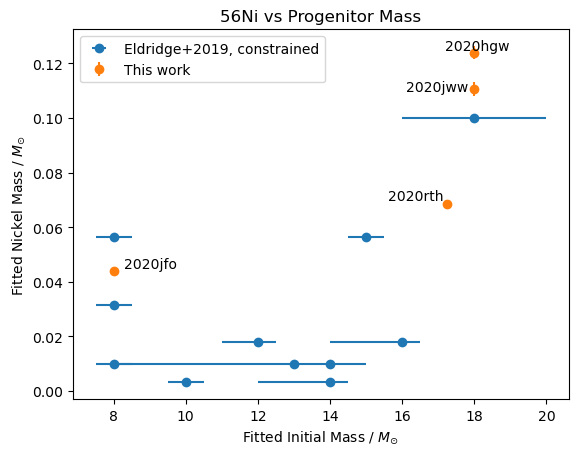

In [11]:
cons_init = [8.0, 8.0, 8.0, 10.0, 12.0, 13.0, 14.0, 14.0, 15.0, 16.0, 18.0] #Eldridge constrained progenitor masses 
cons_init_upper = [.5, .5, .5, .5, .5, .5, .5, 1, .5, .5, 2]
cons_init_lower = [.5, .5, .5, .5, 1, 5, 2, .5, .5, 2, 2]
cons_init_asym = [cons_init_lower, cons_init_upper]

hgw_cons = np.interp(hgw_ni, CURVE_cons, cons_init)
jfo_cons = np.interp(jfo_ni, CURVE_cons, cons_init)
jww_cons = np.interp(jww_ni, CURVE_cons, cons_init)
rth_cons = np.interp(rth_ni, CURVE_cons, cons_init)

print(f'hgw_cons:{hgw_cons}, jfo_cons:{jfo_cons}, jww_cons:{jww_cons}, rth_cons:{rth_cons}')

cons_init_array = np.array([hgw_cons, jfo_cons, jww_cons, rth_cons])
plt.errorbar(cons_init, CURVE_cons, xerr = cons_init_asym, fmt = 'o', label = 'Eldridge+2019, constrained')
plt.errorbar(cons_init_array, nickel_masses, yerr = asymmetric_y, fmt = 'o', label = 'This work')
plt.xlabel('Fitted Initial Mass / $M_{\odot}$')
plt.ylabel('Fitted Nickel Mass / $M_{\odot}$')
plt.text(8.3, 0.045, '2020jfo')
plt.text(17.2, 0.125, '2020hgw')
plt.text(16.1, 0.11, '2020jww')
plt.text(15.6, 0.07, '2020rth')
plt.legend()
plt.title('56Ni vs Progenitor Mass')

Text(0.5, 1.0, '56Ni vs Progenitor Mass')

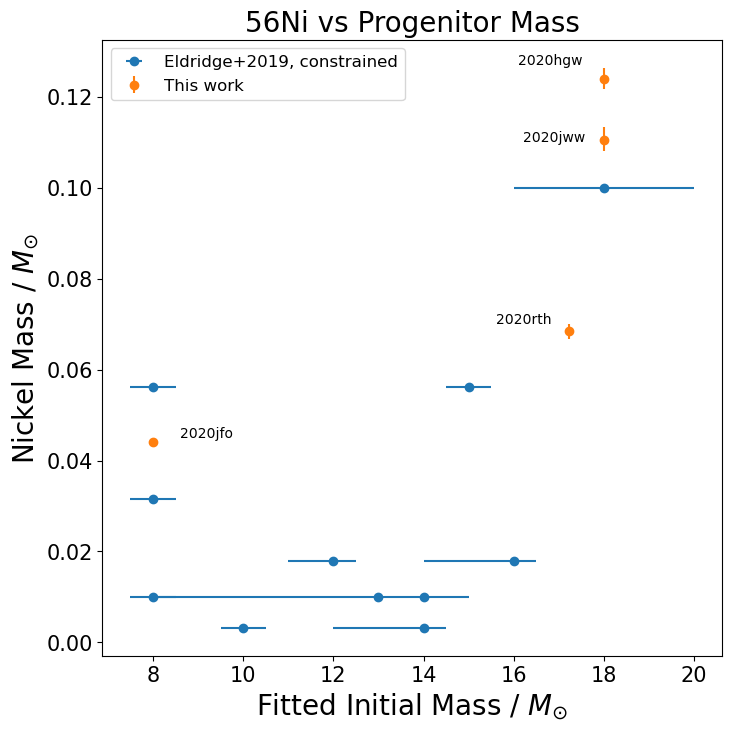

In [12]:
plt.figure(figsize=(8,8))
# plt.errorbar(uncons_init, CURVE_uncons, xerr = uncons_asym_init, fmt = 'o', label = 'Eldridge+2019, unconstrained')
plt.errorbar(cons_init, CURVE_cons, xerr = cons_init_asym, fmt = 'o', label = 'Eldridge+2019, constrained')
plt.errorbar(cons_init_array, nickel_masses, yerr = asymmetric_y, fmt = 'o', label = 'This work')
plt.xlabel('Fitted Initial Mass / $M_{\odot}$', fontsize = 20)
plt.ylabel('Nickel Mass / $M_{\odot}$', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.text(8.6, 0.045, '2020jfo')
plt.text(16.1, 0.127, '2020hgw')
plt.text(16.2, 0.11, '2020jww')
plt.text(15.6, 0.07, '2020rth')
plt.legend(fontsize = 'large')
plt.title('56Ni vs Progenitor Mass', fontsize = 20)

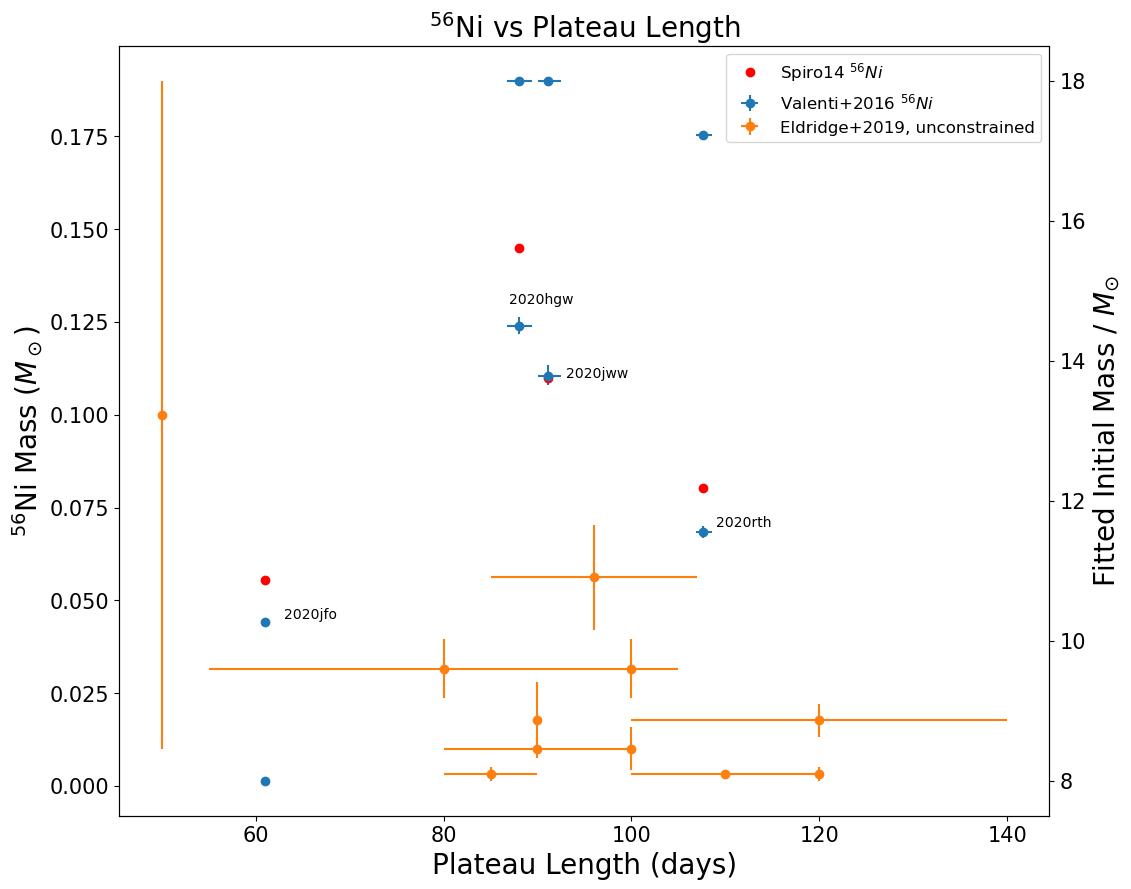

In [13]:
fig, ax1 = plt.subplots(figsize = (12,10))
ax1.errorbar(plateau_length, nickel_masses, xerr=asymmetric_x, yerr=asymmetric_y, fmt = 'o', label = 'Valenti+2016 $^{56}Ni$')
ax1.plot(plateau_length, sp14_masses, color = 'r', label = 'Spiro14 $^{56}Ni $', marker = 'o', linestyle = 'None') 
ax1.errorbar(CURVE_tpt, CURVE_uncons, xerr = CURVE_err, yerr = uncons_lower, fmt = 'o', label = r'Eldridge+2019, unconstrained')
plt.title('$^{56}$Ni vs Plateau Length', fontsize = 20)
ax1.set_xlabel('Plateau Length (days)', fontsize = 20)
ax1.set_ylabel('$^{56}$Ni Mass $(M_\odot)$', fontsize = 20)
ax1.tick_params(axis='both', labelsize = 15)
ax1.text(63, 0.045, '2020jfo')
ax1.text(87, 0.13, '2020hgw')
ax1.text(93, 0.11, '2020jww')
ax1.text(109, 0.07, '2020rth')
ax1.legend(loc = 1, fontsize = 'large')
ax2 = ax1.twinx()
ax2.errorbar(plateau_length, cons_init_array, xerr = asymmetric_x, fmt = 'o')
ax2.set_ylabel('Fitted Initial Mass / $M_{\odot}$', fontsize = 20)
ax2.tick_params(axis='y', labelsize = 15)


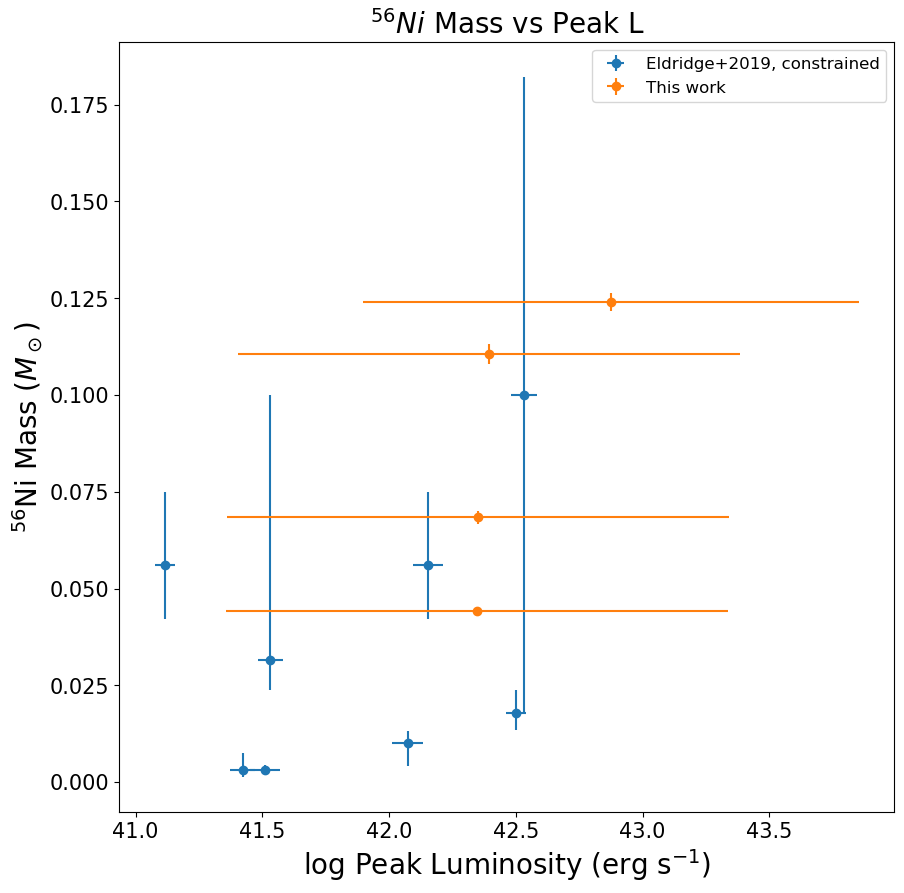

In [14]:
# gd, A, et, cs, my, bk, md, A, aw, ec, ej
peak_lums = [7.499622138688114e+42, 2.224722485025017e+42, 2.4810434522392757e+42, 2.2496933248455278e+42]
lum_errs = [0.98, 0.99, 0.99, 0.99]
CURVEPOP_peak_L = [np.nan, 41.531, 41.115, 41.511, np.nan, np.nan, 41.422, 42.073, 42.154, 42.502, 42.532]
CURVEPOP_Lerrs = [np.nan, 0.05, 0.04, 0.06, np.nan, np.nan, 0.05, 0.06, 0.06, 0.04, 0.05]

figL, axL1 = plt.subplots(figsize = (10,10))
axL1.errorbar(CURVEPOP_peak_L, CURVE_cons, xerr = CURVEPOP_Lerrs, yerr = [cons_lower, cons_upper], marker = 'o', linestyle = 'none', label = 'Eldridge+2019, constrained')
axL1.errorbar(np.log10(peak_lums), nickel_masses, xerr = lum_errs, yerr = asymmetric_y, marker = 'o', linestyle = 'none', label = 'This work')
axL1.set_xlabel('log Peak Luminosity (erg s$^{-1}$)', fontsize = 20)
axL1.set_ylabel('$^{56}$Ni Mass $(M_\odot)$', fontsize = 20)
axL1.set_title('$^{56}Ni$ Mass vs Peak L', fontsize = 20)
axL1.tick_params(axis='both', labelsize = 15)
axL1.legend(fontsize = 'larger')

In [15]:
peak_lums = [7.499622138688114e+42, 2.224722485025017e+42, 2.4810434522392757e+42, 2.2496933248455278e+42]
log_peak_lums = np.log10(peak_lums)
print(log_peak_lums)

[42.87503938 42.34727584 42.39463437 42.35212332]


2003gd - discovered really late (100+d) 

2004A -26d later (eqn3 of Hendry+2006)

2004et - log(L) = 42.5 

2005cs - log(L) = 41.8

2006my -discovered months after explosion

2008bk - log(Lbol) = 41.6 

2009md - log(L) = 41.5 (~25d after explosion)
host gal: NGC 3389 

2012A- log(L) = 42.2 

2012aw - log(L) = 42.15

2012ec - log(L) = 42.18 

2013ej - log(L) = 42.7 

2003gd - discovered 100+ days after explosion 

2006my - discovered months after explosion 

2004A - 26d after explosion, eqn3 of Hendry+2006 has V-band to bol Lum conversion 

2009md -  25d after explosion 

In [16]:
import json

In [17]:
with open('2020hgw.json', 'r') as f:
    hgw_blast = json.load(f)

In [18]:
sfr = {} 
ssfr = {}

In [19]:
def get_sfr(filename):
    with open(filename, 'r') as f:
        data = json.load(f)
    global sfr
    SN = data['transient_name']
    sfr16 = data['global_aperture_host_log_sfr_16']
    sfr50 = data['global_aperture_host_log_sfr_50']
    sfr84 = data['global_aperture_host_log_sfr_84']
    sfr[SN] = [sfr16 , sfr50, sfr84]

In [20]:
def get_ssfr(filename):
    with open(filename, 'r') as f:
        data = json.load(f)
    global ssfr 
    SN = data['transient_name']
    ssfr16 = data['global_aperture_host_log_ssfr_16']
    ssfr50 = data['global_aperture_host_log_ssfr_50']
    ssfr84 = data['global_aperture_host_log_ssfr_84']
    ssfr[SN] = [ssfr16, ssfr50, ssfr84]

In [21]:
get_sfr('2020hgw.json')
get_sfr('2020jww.json')
get_sfr('2020rth.json')
get_sfr('2004A.json')
get_sfr('2006my.json')
get_sfr('2009md.json')
get_sfr('2012A.json')
get_sfr('2012ec.json')
get_ssfr('2020hgw.json')
get_ssfr('2020jww.json')
get_ssfr('2020rth.json')
get_ssfr('2004A.json')
get_ssfr('2006my.json')
get_ssfr('2009md.json')
get_ssfr('2012A.json')
get_ssfr('2012ec.json')

In [22]:
for key, value in sfr.items():
    print(f'key:{key}, value:{value}')
    print(value[1] - value[0])
    print(value[2] - value[1])   

key:2020hgw, value:[-3.327466248936148, -1.7720445395953726, -0.9576599923128308]
1.5554217093407754
0.8143845472825417
key:2020jww, value:[-0.8978091921275773, 0.05726911394328255, 0.33138042446589105]
0.9550783060708599
0.2741113105226085
key:2020rth, value:[-0.3654995942882632, -0.10782668098166627, 0.11511995770658057]
0.2576729133065969
0.22294663868824682
key:2004A, value:[-1.081462147056626, -0.8237738576473858, -0.6025710245799114]
0.25768828940924016
0.22120283306747435
key:2006my, value:[-1.8890326346080297, -0.871783958996402, -0.5383625380887392]
1.0172486756116277
0.3334214209076628
key:2009md, value:[-1.2480150179448342, -0.6454571264294843, -0.44129519978588655]
0.6025578915153499
0.20416192664359772
key:2012A, value:[-1.1346674880312437, -0.6887916264507445, -0.38381778377558606]
0.4458758615804992
0.3049738426751585
key:2012ec, value:[-0.15569071832926665, 0.04018235646956422, 0.22051156699222002]
0.19587307479883087
0.1803292105226558


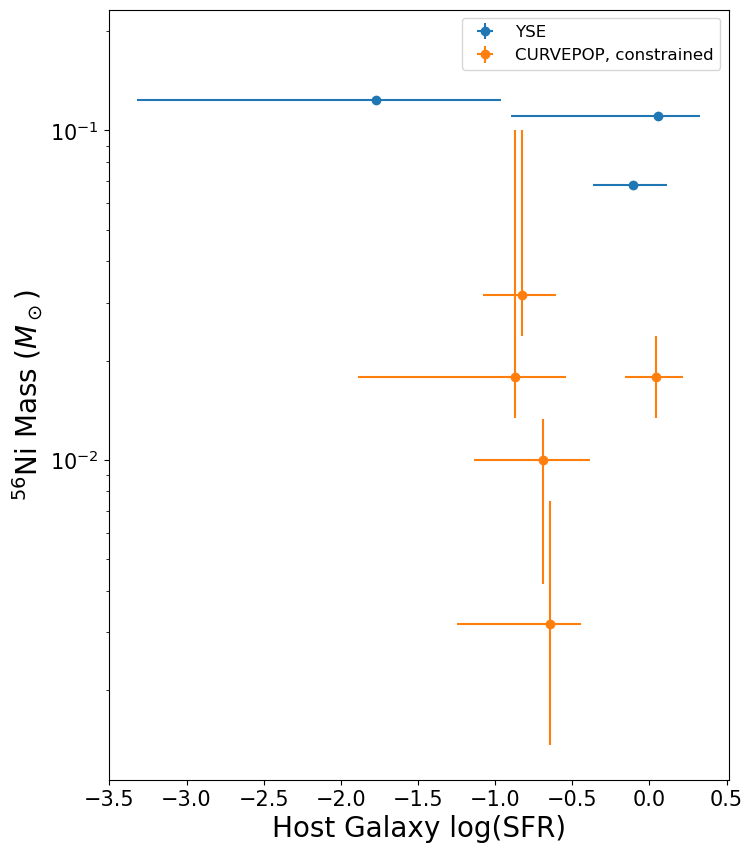

In [23]:
# hgw, jfo, jww, rth 
yse_sfr = [-1.772, np.nan, 0.0573, -0.108]
yse_sfrlow = [1.55, np.nan, 0.955, 0.258]
yse_sfrup = [0.81, np.nan, 0.274, 0.222 ]

# gd, A, et, cs, my, bk, md, A, aw, ec, ej
CURVE_sfr = [np.nan, -0.824, np.nan, np.nan, -0.872, np.nan, -0.645, -0.689, np.nan, 0.040, np.nan]
CURVE_sfrlow = [np.nan, 0.257, np.nan, np.nan, 1.017, np.nan, 0.602, 0.446, np.nan, 0.196, np.nan]
curve_sfrup = [np.nan, 0.221, np.nan, np.nan, 0.333, np.nan, 0.204, 0.305, np.nan, 0.180, np.nan]
plt.figure(figsize=(8,10))
plt.errorbar(yse_sfr, nickel_masses, xerr = [yse_sfrlow, yse_sfrup], yerr = asymmetric_y,fmt = 'o', label ='YSE')
plt.errorbar(CURVE_sfr, CURVE_cons, xerr = [CURVE_sfrlow, curve_sfrup],yerr=[cons_lower, cons_upper], fmt = 'o', label = 'CURVEPOP, constrained')
plt.xlabel('Host Galaxy log(SFR)', fontsize =20)
plt.ylabel('$^{56}$Ni Mass ($M_\odot$)', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 'large')
plt.yscale('log')


In [24]:
print('SSFR')
for key, value in ssfr.items():
    print(f'key:{key}, value:{value}')
    print(value[1] - value[0])
    print(value[2] - value[1]) 

SSFR
key:2020hgw, value:[-12.302309563825549, -10.880988578124834, -10.168179440932427]
1.4213209857007154
0.7128091371924068
key:2020jww, value:[-11.667216301114227, -10.585483787146654, -10.284121233719977]
1.081732513967573
0.30136255342667617
key:2020rth, value:[-10.346422192781457, -10.126449846117668, -9.853671941437568]
0.2199723466637895
0.2727779046800993
key:2004A, value:[-10.550048791904238, -10.282550121935998, -10.001469717201836]
0.2674986699682407
0.28108040473416196
key:2006my, value:[-11.60687074134592, -10.685904596564923, -10.373348881773843]
0.9209661447809978
0.31255571479107935
key:2009md, value:[-10.733696113940741, -10.098348733253875, -9.79055339831567]
0.6353473806868664
0.30779533493820566
key:2012A, value:[-10.210638541454816, -9.619803862667125, -9.004282928631302]
0.5908346787876919
0.615520934035823
key:2012ec, value:[-10.463140139908099, -10.25911798609481, -10.063441408498397]
0.20402215381328936
0.19567657759641222


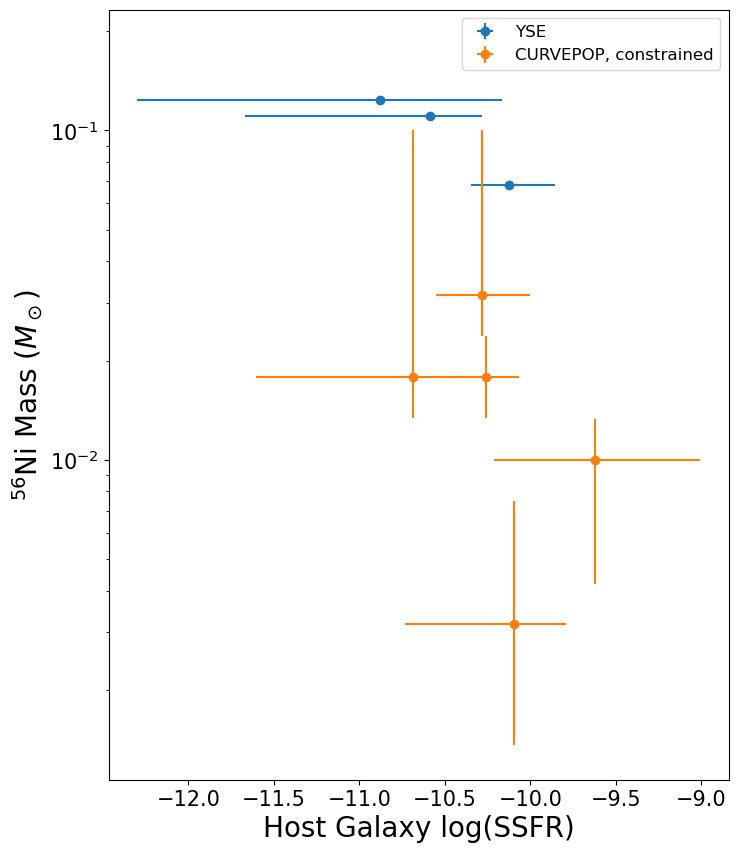

In [25]:
yse_ssfr = [-10.881, np.nan, -10.585, -10.126]
yse_ssfrlo = [1.421, np.nan, 1.082, 0.220]
yse_ssfrup = [0.713, np.nan, 0.301, 0.272]

CURVE_ssfr = [np.nan, -10.283, np.nan, np.nan, -10.686, np.nan, -10.098, -9.620, np.nan, -10.259, np.nan]
CURVE_ssfrlo = [np.nan, 0.267, np.nan, np.nan, 0.921, np.nan, 0.635, 0.591, np.nan, 0.204, np.nan]
CURVE_ssfrup = [np.nan, 0.281, np.nan, np.nan, 0.313, np.nan, 0.308, 0.616, np.nan, 0.196, np.nan]

plt.figure(figsize=(8,10))
plt.errorbar(yse_ssfr, nickel_masses, xerr = [yse_ssfrlo, yse_ssfrup], yerr = asymmetric_y,fmt = 'o', label ='YSE')
plt.errorbar(CURVE_ssfr, CURVE_cons, xerr = [CURVE_ssfrlo, CURVE_ssfrup],yerr=[cons_lower, cons_upper], fmt = 'o', label = 'CURVEPOP, constrained')
plt.xlabel('Host Galaxy log(SSFR)', fontsize =20)
plt.ylabel('$^{56}$Ni Mass ($M_\odot$)', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 'large')
plt.yscale('log')